In [2]:
# Importing Packages and Libraries
import shap
import pandas as pd
import xgboost as xgb
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, OneHotEncoder

# 1. Feature Preperation for X-Grad Boost

In [3]:
# Load data
file_path = '/Users/paulahofmann/Documents/Coding/Online-Review/FeaturePreperation/Data_with_Features/Final Data/Hedonic_Final.csv'
df = pd.read_csv(file_path)

In [4]:
# Drop unnecessary columns
columns_to_drop = ['title_x', 'text', 'images', 'asin', 'parent_asin', 'user_id',
       'timestamp', 'verified_purchase', 'text_cleaned',
       'text_cleaned1','main_category','features','neutral_score','day_of_week',]
df.drop(columns=columns_to_drop, inplace=True)

In [5]:
# Mapping dictionary for sentiment transformation
sentiment_mapping = {'positive': 2, 'neutral': 1, 'negative': 0}

# Using map function to create a new column 'sentiment_c' with transformed values
df['sentiment_c'] = df['Sentiment_Classification'].map(sentiment_mapping)

In [6]:
# Create a new column 'helpful' based on reviews being helfpul or not helpful
df['helpful'] = (df['helpful_vote'] > 0).astype(int)


In [7]:
# Define features and target variable
features = ['rating','sentiment', 'word_count', 'sent_count', 'sent_length', 'title_length', 'elap_days',
            'image', 'ver_purch', '#nouns', '#adj', '#adv', 'subjective_score', 'FRE', 'product']
target = 'helpful'

In [8]:
# Convert 'product' column to categorical type
df['product'] = df['product'].astype('category')

# Prepare  X and y
X = df[features]
y = df[target]

In [9]:
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

# Define categorical and numerical features
categorical_features = ['product']
numerical_features = ['rating','sentiment', 'word_count', 'sent_count', 'sent_length', 'title_length', 'elap_days',
                      'image', 'ver_purch', '#nouns', '#adj', '#adv', 'subjective_score', 'FRE']

# Initialize ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(), categorical_features),  # One-hot encode 'product'
        ("num", MinMaxScaler(), numerical_features),     # Scale numerical features
    ]
)

# Fit and transform the data
X_preprocessed = preprocessor.fit_transform(X)

# Retrieve column names for the one-hot encoded features
cat_column_names = preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_features)

# Combine column names for the transformed features
all_column_names = np.concatenate([cat_column_names, numerical_features])

# Convert the transformed data back to a DataFrame
X = pd.DataFrame(X_preprocessed, columns=all_column_names)

# 1. Basic X-Grad Boost Model

In [10]:
# Split data for test and training data
X_train, X_test, y_train, y_test = train_test_split(
    df[features],  
    df[target], 
    test_size=0.2,  
    random_state=42  # Set a random seed for reproducibility
)

In [11]:
from sklearn.model_selection import StratifiedKFold

# Create a combined column for stratification
df['stratify'] = df['helpful'].astype(str) + "_" + df['product'].astype(str)

# Define StratifiedKFold
skf = StratifiedKFold(n_splits=4)

stratify = df['stratify']

# Splitting the data
for train_index, test_index in skf.split(X, stratify):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    # Print the shapes of the resulting splits to check
    print("X_train shape:", X_train.shape)
    print("X_test shape:", X_test.shape)
    print("y_train shape:", y_train.shape)
    print("y_test shape:", y_test.shape)

    # Optionally, you can check the distribution in each split
    print("Train stratify distribution:\n", y_train.value_counts(normalize=True))
    print("Test stratify distribution:\n", y_test.value_counts(normalize=True))


X_train shape: (14054, 18)
X_test shape: (4685, 18)
y_train shape: (14054,)
y_test shape: (4685,)
Train stratify distribution:
 helpful
0    0.828234
1    0.171766
Name: proportion, dtype: float64
Test stratify distribution:
 helpful
0    0.828388
1    0.171612
Name: proportion, dtype: float64
X_train shape: (14054, 18)
X_test shape: (4685, 18)
y_train shape: (14054,)
y_test shape: (4685,)
Train stratify distribution:
 helpful
0    0.828305
1    0.171695
Name: proportion, dtype: float64
Test stratify distribution:
 helpful
0    0.828175
1    0.171825
Name: proportion, dtype: float64
X_train shape: (14054, 18)
X_test shape: (4685, 18)
y_train shape: (14054,)
y_test shape: (4685,)
Train stratify distribution:
 helpful
0    0.828305
1    0.171695
Name: proportion, dtype: float64
Test stratify distribution:
 helpful
0    0.828175
1    0.171825
Name: proportion, dtype: float64
X_train shape: (14055, 18)
X_test shape: (4684, 18)
y_train shape: (14055,)
y_test shape: (4684,)
Train stratify di

In [12]:
# Convert y_train and y_test to a 2D array
y_train = y_train.values.reshape(-1, 1)
y_test = y_test.values.reshape(-1, 1)

# Create an instance of MinMaxScaler for target variable
scaler = MinMaxScaler(feature_range=(0, 1))  # Set the feature range to be between 0 and 1

# Scale the target variable
y_train = scaler.fit_transform(y_train)
y_test = scaler.transform(y_test)

In [29]:
import xgboost as xgb
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report,f1_score, roc_auc_score
from sklearn.model_selection import cross_val_score

# Train model with default hyperparameters
xgb_cls_default = xgb.XGBClassifier()

xgb_cls_default.fit(X_train, y_train)

# Predictions on test data
y_pred_default = xgb_cls_default.predict(X_test)

# Model evaluation
accuracy = accuracy_score(y_test, y_pred_default)
conf_matrix = confusion_matrix(y_test, y_pred_default)
cls_report = classification_report(y_test, y_pred_default)

print("\nDefault Model Evaluation:")
print(f"Accuracy: {accuracy}")

# Calculate F1 score
f1 = f1_score(y_test, y_pred_default)
print("F1 Score:", f1)

# Calculate AUC
auc = roc_auc_score(y_test, y_pred_default)
print("AUC:", auc)

print("Confusion Matrix:")
print(conf_matrix)
print("Classification Report:")
print(cls_report)

# Perform 5-fold cross-validation
cv_scores = cross_val_score(xgb_cls_default, X_train, y_train, cv=5, scoring='accuracy')
accuracy_cv_mean = cv_scores.mean()
print("Mean Cross-Validated Accuracy:", accuracy_cv_mean)



Default Model Evaluation:
Accuracy: 0.8704099060631939
F1 Score: 0.5540044085231448
AUC: 0.7112568600297481
Confusion Matrix:
[[3700  180]
 [ 427  377]]
Classification Report:
              precision    recall  f1-score   support

         0.0       0.90      0.95      0.92      3880
         1.0       0.68      0.47      0.55       804

    accuracy                           0.87      4684
   macro avg       0.79      0.71      0.74      4684
weighted avg       0.86      0.87      0.86      4684

Mean Cross-Validated Accuracy: 0.7856278904304518


## 1.2 Feature Importance with Shap Values

[16:23:40] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_b6b50u1t0e/croot/xgboost-split_1713972723244/work/cpp_src/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


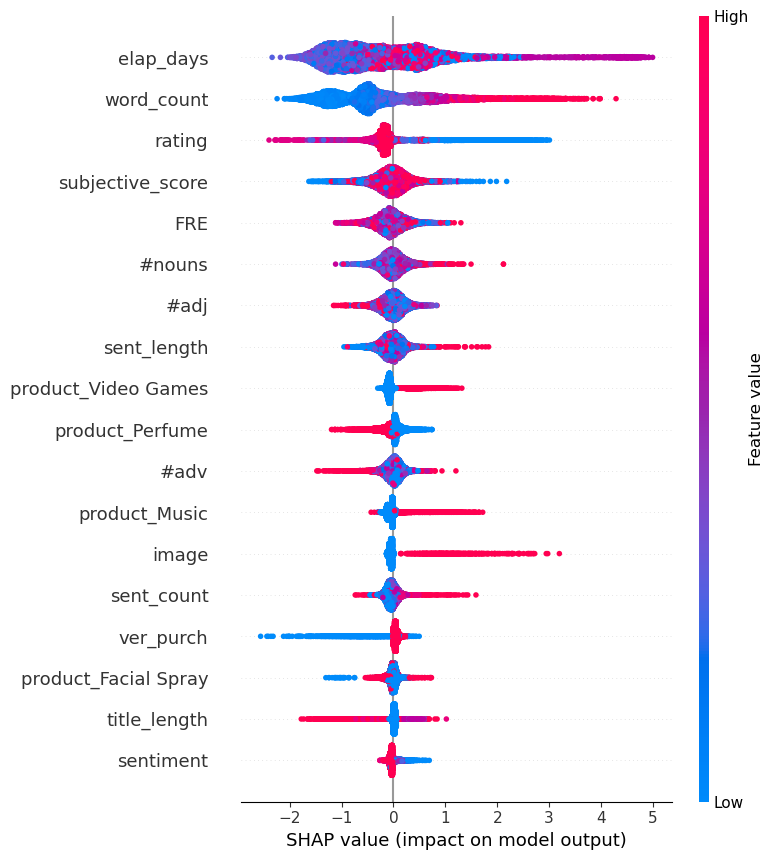

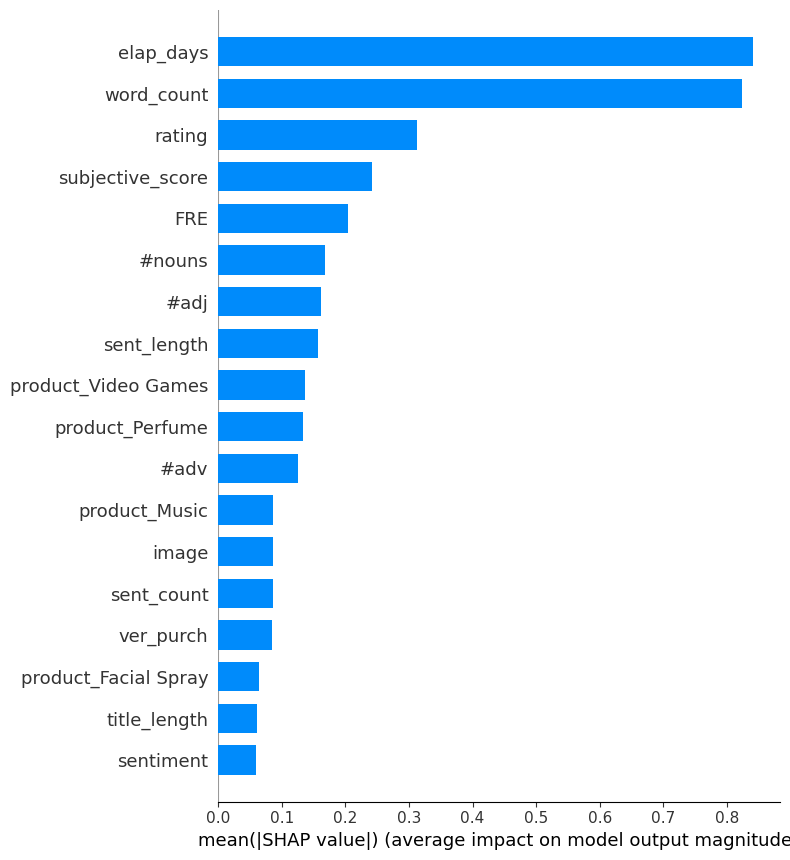

In [30]:
# Create SHAP explainer
explainer = shap.TreeExplainer(xgb_cls_default)

# Calculate SHAP values for the dataset
shap_values = explainer.shap_values(X_train)

# Plot the SHAP summary plot
shap.summary_plot(shap_values, X_train)

# Create a beeswarm plot
shap.summary_plot(shap_values, X_train, plot_type="bar", show=False)
plt.show()

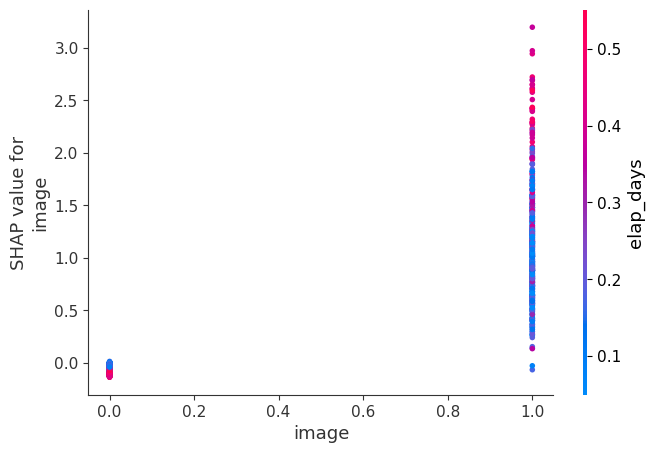

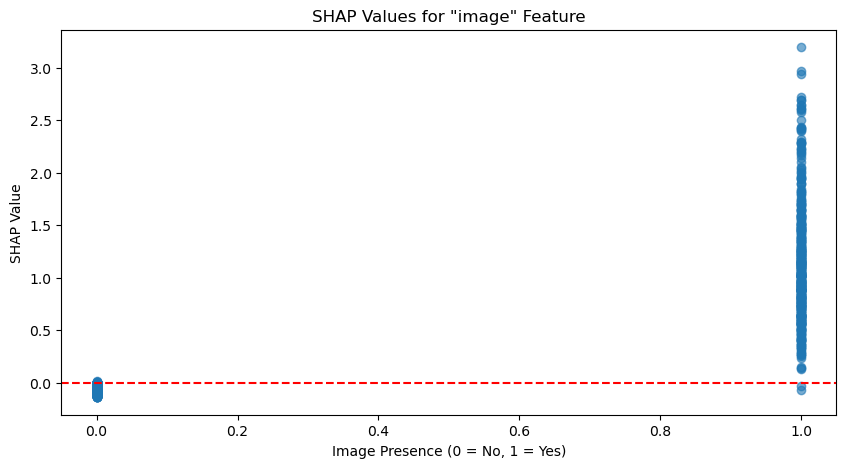

In [15]:
# Plot specifically for the 'image' feature
shap.dependence_plot('image', shap_values, X_train)

# Extract SHAP values for the 'image' feature
image_shap_values = shap_values[:, X_train.columns.get_loc('image')]

# Plot SHAP values for 'image'
plt.figure(figsize=(10, 5))
plt.scatter(X_train['image'], image_shap_values, alpha=0.6)
plt.axhline(0, color='red', linestyle='--')
plt.title('SHAP Values for "image" Feature')
plt.xlabel('Image Presence (0 = No, 1 = Yes)')
plt.ylabel('SHAP Value')
plt.show()


In [16]:
# Calculate the mean of the absolute SHAP values for each feature
average_shap_values_train = np.abs(shap_values).mean(axis=0)


In [17]:
# Create a DataFrame for the features and their average SHAP values
shap_df_train = pd.DataFrame({
    'features': X_train.columns,
    'average_shap_value': average_shap_values_train
})

# Sort the DataFrame based on the average SHAP values
shap_df_train_sorted = shap_df_train.sort_values(by='average_shap_value', ascending=False)

# Display the sorted DataFrame
print(shap_df_train_sorted)

                features  average_shap_value
10             elap_days            0.841319
6             word_count            0.823888
4                 rating            0.313055
16      subjective_score            0.241612
17                   FRE            0.204981
13                #nouns            0.167688
14                  #adj            0.161943
8            sent_length            0.156784
3    product_Video Games            0.135876
2        product_Perfume            0.133999
15                  #adv            0.125977
1          product_Music            0.086944
11                 image            0.085977
7             sent_count            0.085931
12             ver_purch            0.084411
0   product_Facial Spray            0.063579
9           title_length            0.060835
5              sentiment            0.058828


# 2. Applying SMOTE for Imbalanced Dataset

In [18]:
from imblearn.over_sampling import SMOTE

# Apply SMOTE to X_train and y_train
smote = SMOTE(random_state=42,sampling_strategy={1: 8000})
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

# Check the class distribution after resampling
print("Class distribution after SMOTE:")
print(pd.Series(y_train_balanced).value_counts())



Class distribution after SMOTE:
0.0    11641
1.0     8000
Name: count, dtype: int64


In [19]:
# Train model with default hyperparameters
xgb_cls_SMOTE = xgb.XGBClassifier()

xgb_cls_SMOTE.fit(X_train_balanced, y_train_balanced)

# Predictions on test data
y_pred_default = xgb_cls_SMOTE.predict(X_test)

# Model evaluation
accuracy = accuracy_score(y_test, y_pred_default)
conf_matrix = confusion_matrix(y_test, y_pred_default)
cls_report = classification_report(y_test, y_pred_default)

print("\nDefault Model Evaluation:")
print(f"Accuracy: {accuracy}")
print("Confusion Matrix:")
print(conf_matrix)
print("Classification Report:")
print(cls_report)

# Perform 5-fold cross-validation
cv_scores = cross_val_score(xgb_cls_SMOTE, X_train_balanced, y_train_balanced, cv=5, scoring='accuracy')
accuracy_cv_mean = cv_scores.mean()
print("Mean Cross-Validated Accuracy:", accuracy_cv_mean)


Default Model Evaluation:
Accuracy: 0.860802732707088
Confusion Matrix:
[[3610  270]
 [ 382  422]]
Classification Report:
              precision    recall  f1-score   support

         0.0       0.90      0.93      0.92      3880
         1.0       0.61      0.52      0.56       804

    accuracy                           0.86      4684
   macro avg       0.76      0.73      0.74      4684
weighted avg       0.85      0.86      0.86      4684

Mean Cross-Validated Accuracy: 0.7412190749344656


In [20]:
# With considering inbalanced data
from collections import Counter
sqrt = np.sqrt

# Assuming y_train is your ndarray
counts = Counter(y_train.flatten())

# counts[0] will give you the count of 0s
# counts[1] will give you the count of 1s
count_of_zeros = counts[0]
count_of_ones = counts[1]

# Calculate scale_pos_weight
weight_ratio = sqrt(count_of_zeros /count_of_ones)

print("Class distribution in the training set:", counts)
print("scale_pos_weight:", weight_ratio)

Class distribution in the training set: Counter({0.0: 11641, 1.0: 2414})
scale_pos_weight: 2.1959705510646836


# 3. Hyperparameter tuning

In [21]:
# import packages for hyperparameters tuning
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe
space={'max_depth': hp.quniform("max_depth", 3, 18, 1),
        'gamma': hp.uniform ('gamma', 1,9),
        'reg_alpha' : hp.quniform('reg_alpha', 40,180,1),
        'reg_lambda' : hp.uniform('reg_lambda', 0,1),
        'colsample_bytree' : hp.uniform('colsample_bytree', 0.5,1),
        'min_child_weight' : hp.quniform('min_child_weight', 0, 10, 1),
        'n_estimators': 180,
        'seed': 0
    }

def objective(space):
    clf=xgb.XGBClassifier(
                    n_estimators =space['n_estimators'], 
                    max_depth = int(space['max_depth']), 
                    gamma = space['gamma'],
                    reg_alpha = int(space['reg_alpha']),
                    min_child_weight=int(space['min_child_weight']),
                    colsample_bytree=int(space['colsample_bytree']))
    
    evaluation = [( X_train_balanced, y_train_balanced), ( X_test, y_test)]
    
    clf.fit(X_train_balanced, y_train_balanced,
            eval_set=evaluation, eval_metric="auc",
            early_stopping_rounds=10,verbose=False)
    

    pred = clf.predict(X_test)
    accuracy = accuracy_score(y_test, pred>0.5)
    print ("SCORE:", accuracy)
    return {'loss': -accuracy, 'status': STATUS_OK }

In [22]:
trials = Trials()

best_hyperparams = fmin(fn = objective,
                        space = space,
                        algo = tpe.suggest,
                        max_evals = 100,
                        trials = trials)

print("The best hyperparameters are : ","\n")
print(best_hyperparams)

  0%|          | 0/100 [00:00<?, ?trial/s, best loss=?]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                 
0.8202391118701964                                     
  1%|          | 1/100 [00:00<00:36,  2.73trial/s, best loss: -0.8202391118701964]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                            
0.8302732707087959                                                                
  2%|▏         | 2/100 [00:00<00:44,  2.20trial/s, best loss: -0.8302732707087959]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                            
0.8153287788215201                                                                
  3%|▎         | 3/100 [00:01<00:39,  2.47trial/s, best loss: -0.8302732707087959]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                            
0.8349701110162254                                                                
  4%|▍         | 4/100 [00:01<00:34,  2.75trial/s, best loss: -0.8349701110162254]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                            
0.8326216908625107                                                                
  5%|▌         | 5/100 [00:01<00:33,  2.88trial/s, best loss: -0.8349701110162254]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                            
0.829205807002562                                                                 
  6%|▌         | 6/100 [00:02<00:28,  3.30trial/s, best loss: -0.8349701110162254]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                            
0.8296327924850555                                                                
  7%|▋         | 7/100 [00:02<00:28,  3.23trial/s, best loss: -0.8349701110162254]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                            
0.8208795900939369                                                                
  8%|▊         | 8/100 [00:02<00:28,  3.22trial/s, best loss: -0.8349701110162254]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                            
0.8317677198975235                                                                
  9%|▉         | 9/100 [00:03<00:29,  3.05trial/s, best loss: -0.8349701110162254]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                            
0.8309137489325363                                                                
 10%|█         | 10/100 [00:03<00:32,  2.81trial/s, best loss: -0.8349701110162254]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.8343296327924851                                                                 
SCORE:                                                                             
0.8087105038428694                                                                 
 12%|█▏        | 12/100 [00:04<00:27,  3.18trial/s, best loss: -0.8349701110162254]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.8262169086251068                                                                 
 13%|█▎        | 13/100 [00:04<00:26,  3.30trial/s, best loss: -0.8349701110162254]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.8332621690862511                                                                 
SCORE:                                                                             
0.8089239965841162                                                                 
 15%|█▌        | 15/100 [00:04<00:21,  3.87trial/s, best loss: -0.8349701110162254]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.8324081981212639                                                                 
 16%|█▌        | 16/100 [00:05<00:23,  3.56trial/s, best loss: -0.8349701110162254]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.8371050384286934                                                                 
 17%|█▋        | 17/100 [00:05<00:29,  2.77trial/s, best loss: -0.8371050384286934]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.8268573868488471                                                                 
 18%|█▊        | 18/100 [00:05<00:27,  2.99trial/s, best loss: -0.8371050384286934]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.8287788215200683                                                                 
 19%|█▉        | 19/100 [00:06<00:27,  2.97trial/s, best loss: -0.8371050384286934]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.8200256191289497                                                                 
 20%|██        | 20/100 [00:06<00:27,  2.87trial/s, best loss: -0.8371050384286934]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.8435098206660974                                                                 
 21%|██        | 21/100 [00:07<00:33,  2.35trial/s, best loss: -0.8435098206660974]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.837532023911187                                                                  
 22%|██▏       | 22/100 [00:07<00:31,  2.44trial/s, best loss: -0.8435098206660974]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.8373185311699403                                                                 
 23%|██▎       | 23/100 [00:08<00:30,  2.57trial/s, best loss: -0.8435098206660974]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.8437233134073442                                                                 
 24%|██▍       | 24/100 [00:08<00:34,  2.23trial/s, best loss: -0.8437233134073442]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.8347566182749786                                                                 
 25%|██▌       | 25/100 [00:08<00:32,  2.29trial/s, best loss: -0.8437233134073442]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.8343296327924851                                                                 
 26%|██▌       | 26/100 [00:09<00:30,  2.44trial/s, best loss: -0.8437233134073442]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.8324081981212639                                                                 
 27%|██▋       | 27/100 [00:09<00:30,  2.39trial/s, best loss: -0.8437233134073442]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.8287788215200683                                                                 
 28%|██▊       | 28/100 [00:10<00:30,  2.34trial/s, best loss: -0.8437233134073442]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.827070879590094                                                                  
 29%|██▉       | 29/100 [00:10<00:29,  2.38trial/s, best loss: -0.8437233134073442]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.8204526046114432                                                                 
 30%|███       | 30/100 [00:11<00:34,  2.04trial/s, best loss: -0.8437233134073442]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.8304867634500427                                                                 
 31%|███       | 31/100 [00:11<00:33,  2.05trial/s, best loss: -0.8437233134073442]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.8134073441502989                                                                 
 32%|███▏      | 32/100 [00:12<00:30,  2.22trial/s, best loss: -0.8437233134073442]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.842869342442357                                                                  
 33%|███▎      | 33/100 [00:12<00:32,  2.09trial/s, best loss: -0.8437233134073442]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.8330486763450042                                                                 
 34%|███▍      | 34/100 [00:12<00:28,  2.32trial/s, best loss: -0.8437233134073442]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.8373185311699403                                                                 
 35%|███▌      | 35/100 [00:13<00:38,  1.71trial/s, best loss: -0.8437233134073442]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.8341161400512382                                                                 
 36%|███▌      | 36/100 [00:14<00:33,  1.92trial/s, best loss: -0.8437233134073442]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.829205807002562                                                                  
 37%|███▋      | 37/100 [00:14<00:32,  1.95trial/s, best loss: -0.8437233134073442]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.8234415029888984                                                                 
 38%|███▊      | 38/100 [00:15<00:34,  1.82trial/s, best loss: -0.8437233134073442]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.837532023911187                                                                  
 39%|███▉      | 39/100 [00:15<00:29,  2.04trial/s, best loss: -0.8437233134073442]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.8279248505550811                                                                 
 40%|████      | 40/100 [00:16<00:25,  2.33trial/s, best loss: -0.8437233134073442]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.8349701110162254                                                                 
 41%|████      | 41/100 [00:16<00:23,  2.50trial/s, best loss: -0.8437233134073442]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.832194705380017                                                                  
 42%|████▏     | 42/100 [00:16<00:22,  2.62trial/s, best loss: -0.8437233134073442]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.8317677198975235                                                                 
SCORE:                                                                             
0.8091374893253629                                                                 
 44%|████▍     | 44/100 [00:17<00:18,  3.06trial/s, best loss: -0.8437233134073442]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.8159692570452605                                                                 
SCORE:                                                                             
 45%|████▌     | 45/100 [00:17<00:18,  2.95trial/s, best loss: -0.8437233134073442]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



0.8074295473953885                                                                 
 46%|████▌     | 46/100 [00:17<00:16,  3.27trial/s, best loss: -0.8437233134073442]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.8313407344150299                                                                 
 47%|████▋     | 47/100 [00:18<00:17,  2.95trial/s, best loss: -0.8437233134073442]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.8289923142613151                                                                 
 48%|████▊     | 48/100 [00:18<00:18,  2.85trial/s, best loss: -0.8437233134073442]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.8138343296327925                                                                 
 49%|████▉     | 49/100 [00:19<00:19,  2.66trial/s, best loss: -0.8437233134073442]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.8313407344150299                                                                 
 50%|█████     | 50/100 [00:19<00:20,  2.46trial/s, best loss: -0.8437233134073442]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.8168232280102476                                                                 
SCORE:                                                                             
0.8234415029888984                                                                 
 52%|█████▏    | 52/100 [00:20<00:15,  3.15trial/s, best loss: -0.8437233134073442]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.8353970964987191                                                                 
 53%|█████▎    | 53/100 [00:20<00:16,  2.86trial/s, best loss: -0.8437233134073442]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.8302732707087959                                                                 
 54%|█████▍    | 54/100 [00:20<00:17,  2.68trial/s, best loss: -0.8437233134073442]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.8368915456874466                                                                 
 55%|█████▌    | 55/100 [00:21<00:16,  2.80trial/s, best loss: -0.8437233134073442]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.8236549957301452                                                                 
 56%|█████▌    | 56/100 [00:21<00:15,  2.91trial/s, best loss: -0.8437233134073442]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.8219470538001707                                                                 
 57%|█████▋    | 57/100 [00:21<00:14,  3.03trial/s, best loss: -0.8437233134073442]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.8272843723313408                                                                 
 58%|█████▊    | 58/100 [00:22<00:13,  3.10trial/s, best loss: -0.8437233134073442]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.8279248505550811                                                                 
 59%|█████▉    | 59/100 [00:22<00:13,  3.00trial/s, best loss: -0.8437233134073442]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.8377455166524338                                                                 
 60%|██████    | 60/100 [00:23<00:15,  2.63trial/s, best loss: -0.8437233134073442]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.82066609735269                                                                   
SCORE:                                                                             
0.8247224594363791                                                                 
 62%|██████▏   | 62/100 [00:23<00:11,  3.20trial/s, best loss: -0.8437233134073442]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.8343296327924851                                                                 
 63%|██████▎   | 63/100 [00:23<00:11,  3.16trial/s, best loss: -0.8437233134073442]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.816396242527754                                                                  
 64%|██████▍   | 64/100 [00:24<00:11,  3.22trial/s, best loss: -0.8437233134073442]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.8298462852263023                                                                 
 65%|██████▌   | 65/100 [00:24<00:12,  2.90trial/s, best loss: -0.8437233134073442]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.8341161400512382                                                                 
 66%|██████▌   | 66/100 [00:24<00:11,  2.97trial/s, best loss: -0.8437233134073442]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.842869342442357                                                                  
 67%|██████▋   | 67/100 [00:25<00:12,  2.55trial/s, best loss: -0.8437233134073442]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.8368915456874466                                                                 
 68%|██████▊   | 68/100 [00:26<00:14,  2.18trial/s, best loss: -0.8437233134073442]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.8360375747224594                                                                 
SCORE:                                                                             
0.8309137489325363                                                                 
 70%|███████   | 70/100 [00:26<00:10,  2.78trial/s, best loss: -0.8437233134073442]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.8458582408198121                                                                 
 71%|███████   | 71/100 [00:27<00:12,  2.35trial/s, best loss: -0.8458582408198121]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.8362510674637063                                                                 
 72%|███████▏  | 72/100 [00:27<00:11,  2.36trial/s, best loss: -0.8458582408198121]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.837532023911187                                                                  
 73%|███████▎  | 73/100 [00:27<00:10,  2.56trial/s, best loss: -0.8458582408198121]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.8411614005123825                                                                 
 74%|███████▍  | 74/100 [00:28<00:11,  2.36trial/s, best loss: -0.8458582408198121]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.831127241673783                                                                  
 75%|███████▌  | 75/100 [00:28<00:10,  2.48trial/s, best loss: -0.8458582408198121]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.8377455166524338                                                                 
 76%|███████▌  | 76/100 [00:29<00:09,  2.57trial/s, best loss: -0.8458582408198121]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.8298462852263023                                                                 
SCORE:                                                                             
0.8234415029888984                                                                 
 78%|███████▊  | 78/100 [00:29<00:06,  3.16trial/s, best loss: -0.8458582408198121]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.8315542271562767                                                                 
 79%|███████▉  | 79/100 [00:29<00:06,  3.16trial/s, best loss: -0.8458582408198121]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.829205807002562                                                                  
 80%|████████  | 80/100 [00:30<00:06,  2.95trial/s, best loss: -0.8458582408198121]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.8317677198975235                                                                 
 81%|████████  | 81/100 [00:30<00:06,  2.91trial/s, best loss: -0.8458582408198121]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.8330486763450042                                                                 
 82%|████████▏ | 82/100 [00:31<00:06,  2.74trial/s, best loss: -0.8458582408198121]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.8300597779675492                                                                 
 83%|████████▎ | 83/100 [00:31<00:06,  2.74trial/s, best loss: -0.8458582408198121]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.8345431255337319                                                                 
 84%|████████▍ | 84/100 [00:31<00:05,  2.88trial/s, best loss: -0.8458582408198121]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.837532023911187                                                                  
 85%|████████▌ | 85/100 [00:32<00:05,  2.95trial/s, best loss: -0.8458582408198121]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.8279248505550811                                                                 
 86%|████████▌ | 86/100 [00:32<00:04,  2.92trial/s, best loss: -0.8458582408198121]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.8283518360375747                                                                 
 87%|████████▋ | 87/100 [00:32<00:04,  2.84trial/s, best loss: -0.8458582408198121]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.8255764304013663                                                                 
 88%|████████▊ | 88/100 [00:33<00:04,  2.77trial/s, best loss: -0.8458582408198121]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.8326216908625107                                                                 
 89%|████████▉ | 89/100 [00:33<00:03,  2.91trial/s, best loss: -0.8458582408198121]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.8272843723313408                                                                 
 90%|█████████ | 90/100 [00:33<00:03,  2.75trial/s, best loss: -0.8458582408198121]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.8159692570452605                                                                 
 91%|█████████ | 91/100 [00:34<00:03,  2.95trial/s, best loss: -0.8458582408198121]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.8341161400512382                                                                 
 92%|█████████▏| 92/100 [00:34<00:02,  3.03trial/s, best loss: -0.8458582408198121]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.840734415029889                                                                  
 93%|█████████▎| 93/100 [00:35<00:02,  2.60trial/s, best loss: -0.8458582408198121]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.8341161400512382                                                                 
 94%|█████████▍| 94/100 [00:35<00:02,  2.42trial/s, best loss: -0.8458582408198121]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.8200256191289497                                                                 
 95%|█████████▌| 95/100 [00:35<00:02,  2.48trial/s, best loss: -0.8458582408198121]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.8172502134927413                                                                 
 96%|█████████▌| 96/100 [00:36<00:01,  2.57trial/s, best loss: -0.8458582408198121]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.8191716481639624                                                                 
 97%|█████████▋| 97/100 [00:36<00:01,  2.63trial/s, best loss: -0.8458582408198121]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.8377455166524338                                                                 
 98%|█████████▊| 98/100 [00:36<00:00,  2.75trial/s, best loss: -0.8458582408198121]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.8245089666951324                                                                 
 99%|█████████▉| 99/100 [00:37<00:00,  2.73trial/s, best loss: -0.8458582408198121]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



SCORE:                                                                             
0.8317677198975235                                                                 
100%|██████████| 100/100 [00:37<00:00,  2.66trial/s, best loss: -0.8458582408198121]
The best hyperparameters are :  

{'colsample_bytree': 0.5975923599162888, 'gamma': 3.3176309163683424, 'max_depth': 11.0, 'min_child_weight': 2.0, 'reg_alpha': 40.0, 'reg_lambda': 0.40979803695427724}


In [23]:
best_hyperparams={'colsample_bytree': 0.7811172736299022, 'gamma': 3.2352442730865194, 'max_depth': 14, 'min_child_weight': 3.0, 'reg_alpha': 42.0, 'reg_lambda': 0.48574983894233864}


In [24]:
# Train model with default hyperparameters
xgb_cls_hyp = xgb.XGBClassifier(**best_hyperparams, scale_pos_weight=weight_ratio)

xgb_cls_hyp.fit(X_train, y_train)

# Predictions on test data
y_pred_opt = xgb_cls_hyp.predict(X_test)

# Model evaluation
accuracy = accuracy_score(y_test, y_pred_default)
conf_matrix = confusion_matrix(y_test, y_pred_default)
cls_report = classification_report(y_test, y_pred_default)

print("\nOptimized Model Evaluation:")
print(f"Accuracy: {accuracy}")
print("Confusion Matrix:")
print(conf_matrix)
print("Classification Report:")
print(cls_report)

# Perform 5-fold cross-validation
cv_scores = cross_val_score(xgb_cls_hyp, X_train, y_train, cv=5, scoring='accuracy')
accuracy_cv_mean = cv_scores.mean()
print("Mean Cross-Validated Accuracy:", accuracy_cv_mean)


Optimized Model Evaluation:
Accuracy: 0.860802732707088
Confusion Matrix:
[[3610  270]
 [ 382  422]]
Classification Report:
              precision    recall  f1-score   support

         0.0       0.90      0.93      0.92      3880
         1.0       0.61      0.52      0.56       804

    accuracy                           0.86      4684
   macro avg       0.76      0.73      0.74      4684
weighted avg       0.85      0.86      0.86      4684

Mean Cross-Validated Accuracy: 0.7590892920668801


[16:15:11] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_b6b50u1t0e/croot/xgboost-split_1713972723244/work/cpp_src/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


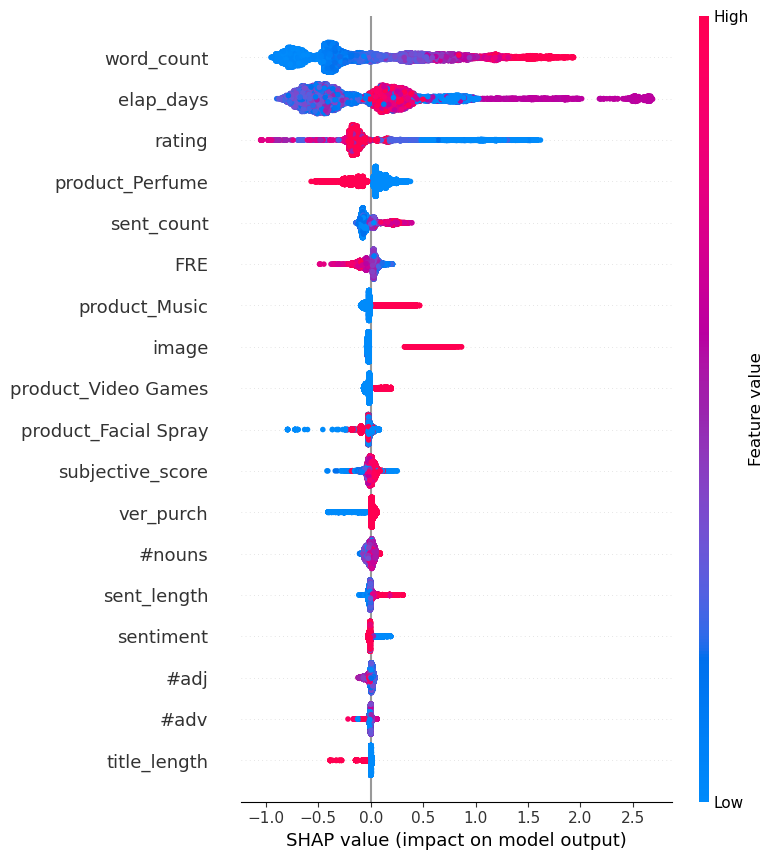

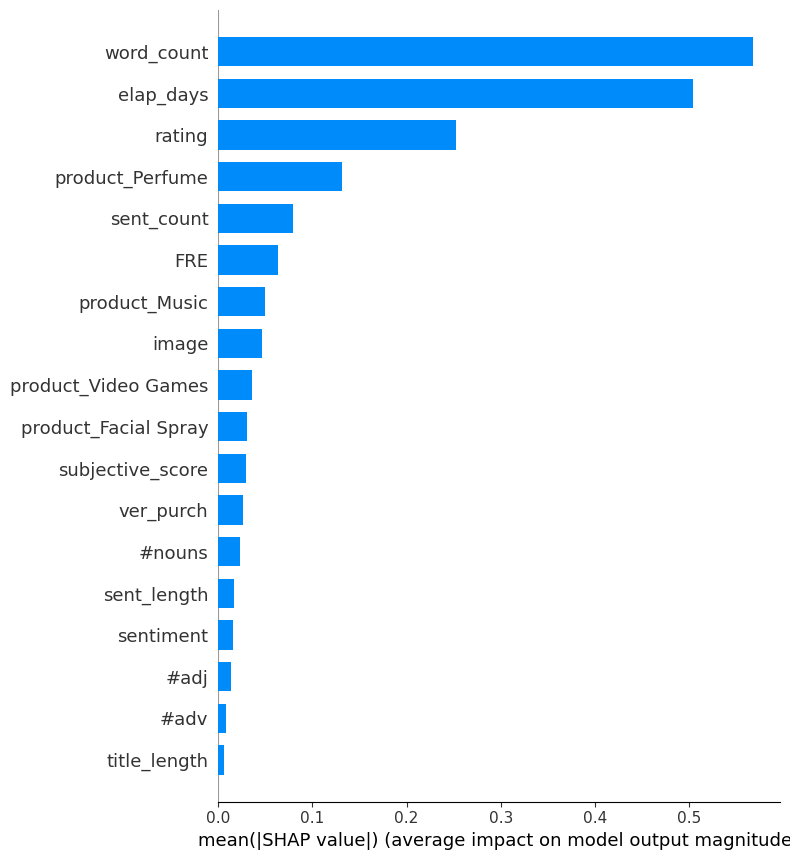

In [25]:
# Create SHAP explainer
explainer = shap.TreeExplainer(xgb_cls_hyp)

# Calculate SHAP values for the dataset
shap_values = explainer.shap_values(X_train_balanced)

# Plot the SHAP summary plot
shap.summary_plot(shap_values, X_train_balanced)

# Create a beeswarm plot
shap.summary_plot(shap_values, X_train_balanced, plot_type="bar", show=False)
plt.show()

Negative Value mean that outcome is negative, review is not helpful. Positive shap values mean a positive outcome, the review is helpful. 

[16:15:14] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_b6b50u1t0e/croot/xgboost-split_1713972723244/work/cpp_src/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


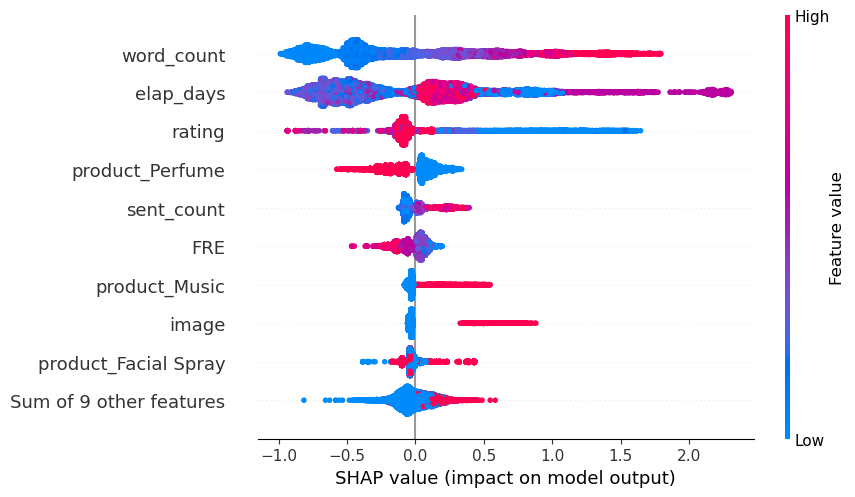

In [26]:
# compute SHAP values
explainer = shap.TreeExplainer(xgb_cls_hyp, X_train_balanced)
shap_values = explainer(X_train_balanced)

shap.plots.beeswarm(shap_values, max_display=10)